# Data Visualization of World Contraceptive Use

This poroject is a demonstration of how to use python for data visualization. Modules used for this project includes pandas, numpy, fuzzywuzzy for data cleaning; geopandas, matplotlib, seaborn, bokeh for plotting. I intend to examine what is the most commonly used contraceptive method worldwide, especially contraceptive use in the United States. When thinking of contraceptive use, most likely, pills and condoms may pop into people's minds, which is true for most developed countries. However, the US seems to be a unique case that worth a close examination.

This project is set out as follows: First, I create a dataset that contains the world and country specific contraceptive information. Then, I provide an overview of contraceptive use around the world. Next, I present the distribution of contraceptive prevalence of various methods for twelve countries and the country specific trends from 1980 to 2017. Lastly, a plot is created to illustrate the trend of six contraceptive methods used in the US from 1955 to 2017.

The data used in this project are publicly available on the UN website. Data can be found here:

[United Nations, Department of Economic and Social Affairs, Population Division (2019). Contraceptive Use by Method 2019: Data Booklet (ST/ESA/SER.A/435).](https://www.un.org/en/development/desa/population/publications/pdf/family/ContraceptiveUseByMethodDataBooklet2019.pdf)

[United Nations, Department of Economic and Social Affairs, Population Division (2019). World Contraceptive Use 2019 (POP/DB/CP/Rev2019).](https://www.un.org/en/development/desa/population/publications/dataset/contraception/wcu2019.asp)

Note: You may need to install additional dependencies for modules used in this project. Plots created from bokeh may not display automatically in jupyter notebook. I recommend You  download this script and data, run locally on your laptop.


In [1]:
import geopandas 
import pandas as pd
import seaborn as sns
import numpy as np
import pycountry # used to identify country code
from fuzzywuzzy import fuzz, process # used to fuzzy merge data
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from bokeh.palettes import Spectral6, Paired ## used to create interactive plot
from bokeh.plotting import figure,  show, output_file
from bokeh.io import output_notebook 
from bokeh.transform import factor_cmap ## use to apply color palette to categorical variables
from bokeh.models import ColumnDataSource, HoverTool,CrosshairTool, SaveTool, PanTool,Legend,Panel, Tabs
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 500)
import warnings
warnings.filterwarnings('ignore')

## Set up
First, let's import a world map from the geopandas module. This is a shapefile without basic information attached. We will later add contraceptive information from our data. A unique column is the "geometry". This variable contais the information we will use to plot the map. Let's first take a look of the data and the map.

In [2]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres')) 
world.head(5)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


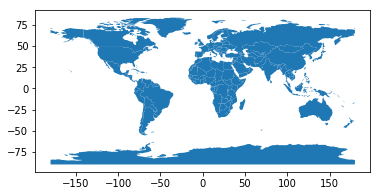

In [3]:
world.plot()

Next, we load the datasets that we will need for our illustrations, data are available under the same folder of my git repo. All three datasets are stored in one spreadsheet. The following code allows python to read them all at once. "country2019" contains contraceptive information for all countries and regions in 2019. "area2019" is a aggregated summary of contraceptive use by region and income levels in 2019. "country_tread" contains yearly country sepcific contraceptive prevalence for decades.

In [4]:
# loading contraceptive data
with pd.ExcelFile('Contraceptive_2019.xls') as xls:
    country2019 = pd.read_excel(xls, 'Sheet1', na_values= ["."])
    area2019 = pd.read_excel(xls, 'Sheet2',na_values= ["."])
    country_trend= pd.read_excel(xls, "Sheet3",na_values= ["."]) 

## Merge data

For the country2019 dataset we also need to perform a management step, in particular,we need to merge the geographic information with the contraceptive information. However, the contraceptive data do not contain a column of unique identifier. A possible way to merge two data ("country2019" and "world") together is based on country names. Here I use a fuzzy method to match two dataset based on the name of each country. A special note: since the fuzzy merge is based on string variables (in our case, the country names), it highly possible to result in undesirable or mismatch. Do check the data after your merging. For our data, it works pretty well.

In [5]:
# The contraceptive data do not contain a col of unique identifier.
# Use fuzzy merge to join two datasets.
def fuzzy_merge(data1, data2, key1, key2, threshold=95, limit=1):
    
    s = data2[key2].tolist()

    m = data1[key1].apply(lambda x: process.extract(x, s, limit=limit))    
    data1['matches'] = m

    m2 = data1['matches'].apply(lambda x: ', '.join([i[0] for i in x if i[1] >= threshold]))
    data1['matches'] = m2

    return data1

In [6]:
match=fuzzy_merge(world, country2019, 'name', 'area')

In [7]:
#match.loc[match['matches'] == ""] ## display countries that have no matches from contraceptive data

In [8]:
World_con = pd.merge(match, country2019, 
                        left_on='matches', 
                        right_on='area',
                        how = 'left'
                       )

In [9]:
# Clean the data 
World_con=World_con[World_con.columns.drop('matches')];
World_con=World_con[World_con.columns.drop('area')]
World_con=World_con[World_con.continent!='Antarctica'] # we remove Antarctica from the data. Nobody lives there anyway.

Let's take a quick inspection of the data. Everything looks fine. We can go head and plotting.

In [10]:
round(World_con.describe(), 2)

,pop_est,gdp_md_est,Any method,Female sterilisation,Male sterilisation,Pill,Injectable,Implant,IUD,Male condom,Rhythm,Withdrawal,Other methods,women(15-49 in thousands),region
count,1.760000e+02,176.00,148.00,136.00,136.00,136.00,136.00,136.00,136.00,136.00,136.00,136.00,136.00,148.00,148.0
mean,4.194935e+07,670681.31,41.33,4.60,0.61,9.80,5.35,1.49,5.16,8.30,1.71,2.64,1.08,11764.28,0.0
std,1.463514e+08,2295416.80,16.16,6.69,1.55,8.88,6.20,2.44,7.32,8.15,1.73,4.06,1.14,41438.57,0.0
min,1.400000e+02,16.00,6.50,0.00,0.00,0.40,0.00,0.00,0.00,0.00,0.00,0.00,0.00,72.00,0.0
25%,3.408326e+06,25945.00,28.98,0.50,0.00,3.08,0.40,0.10,0.70,1.70,0.50,0.40,0.38,1133.00,0.0
50%,1.010473e+07,85045.00,42.40,1.85,0.10,6.25,2.90,0.35,2.05,5.25,1.15,1.20,0.80,2611.00,0.0
75%,2.947544e+07,411950.00,53.92,4.93,0.20,13.55,7.98,1.83,7.30,12.12,2.30,2.95,1.30,8487.00,0.0
max,1.379303e+09,21140000.00,78.00,30.60,9.50,34.40,23.40,14.90,47.00,34.90,9.50,24.50,8.80,354103.00,0.0


## Contraceptive prevalence in the world
### General trend 
#### A world map to show the estimated prevalence of contraceptive use among women of reproductive age

Text(0.1, 0.28, 'Source: United  Nations, Population  Division  (2019).')

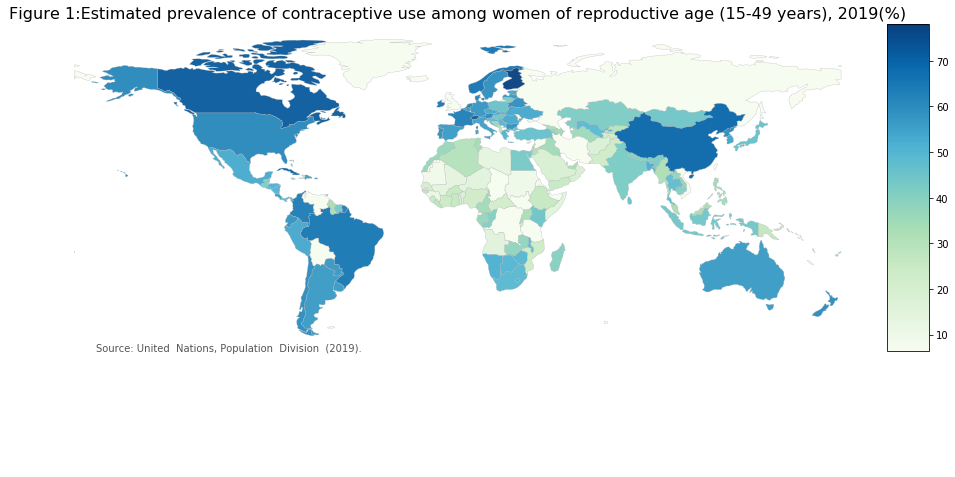

In [11]:
## setup plot and legend
fig, ax = plt.subplots(1, figsize=(16, 17))
divider = make_axes_locatable(ax) # align the legend to the plot
cax = divider.append_axes("right", size="5%", pad=0.1)

World_con.plot(column='Any method', linewidth=0.3, ax=ax, edgecolor='0.7',alpha=0.95,\
               cax=cax, cmap='GnBu',legend= True)
ax.axis('off')# remove the axis

# add plot title and annotation
ax.set_title('Figure 1:Estimated prevalence of contraceptive use among women of reproductive age (15-49 years), 2019(%)',
             fontdict={'fontsize': '16', 'fontweight' : '5','horizontalalignment': 'center'})
ax.annotate('Source: United  Nations, Population  Division  (2019).',xy=(0.1, 0.28),  
            xycoords='figure fraction', horizontalalignment='left', verticalalignment='top',
            fontsize=10, color='#555555')


It is obvious that Northern and Southern America, European countries and China have high levels of contraceptive prevalence. Most African countries have lower levels of contraceptive use. This is consistent with our knowledge that  contraceptive practice is common in developed countries whereas contraception is less popular in developing countries. 

#### Contraceptive use prevalence among women in geographic regions

Next, from the "area2019" dataset, let's pull out the information to make some basic plots. Here, I first extract contraceptive prevalence of all method by geographic regions. Then use catplot from the seaborn module to make a barchart.

In [12]:
g_contra=area2019.iloc[1:9,:2]
g_contra=g_contra.sort_values("Any method", ascending=False) ## sort the values on a decending order 

Text(0.5, 0.98, 'Figure 2: Contraceptive use prevalence in geographic regions: all method (%)')

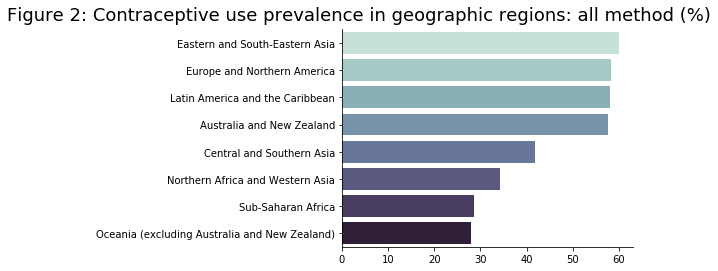

In [13]:
g=sns.catplot(y="area", x="Any method",
              palette=(sns.cubehelix_palette(8, start=.5, rot=-.5)), 
              height=4,aspect=2, kind="bar",  data=g_contra)

## remove y and x labs.
(g.set_ylabels("")
  .set_xlabels("")) 

## setup title    
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Figure 2: Contraceptive use prevalence in geographic regions: all method (%)', 
               fontsize=18)

Figure 2 presents the distribution of contraceptive use prevalence in different regions. Again, Eastern and South-Eastern Asia (especially China and India), Europe, America, Australia and New Zealand have a contraception prevalence around 60%. Africa and some Asia areas have lower prevalence of contraceptive use.

#### Contraceptive use prevalence among women by income levels

In [14]:
inc_contra=area2019.iloc[16:21,[0,1,2,3,4,7,8]] # select income and various contraceptive methods

In [15]:
inc_contra

,area,Any method,Female sterilisation,Male sterilisation,Pill,IUD,Male condom
16,High-income countries,56.6,6.1,3.0,17.2,6.5,14.8
17,Middle-income countries,49.6,13.8,0.6,6.7,9.4,9.9
18,Upper-middle-income countries,61.0,12.6,1.0,7.3,16.3,16.6
19,Lower-middle-income countries,40.1,14.8,0.2,6.3,3.6,4.4
20,Low-income countries,28.0,1.7,0.3,3.8,3.0,2.9


Text(0.5, 0.98, 'Figure 3:Contraceptive use prevalence among women by income levels(%)')

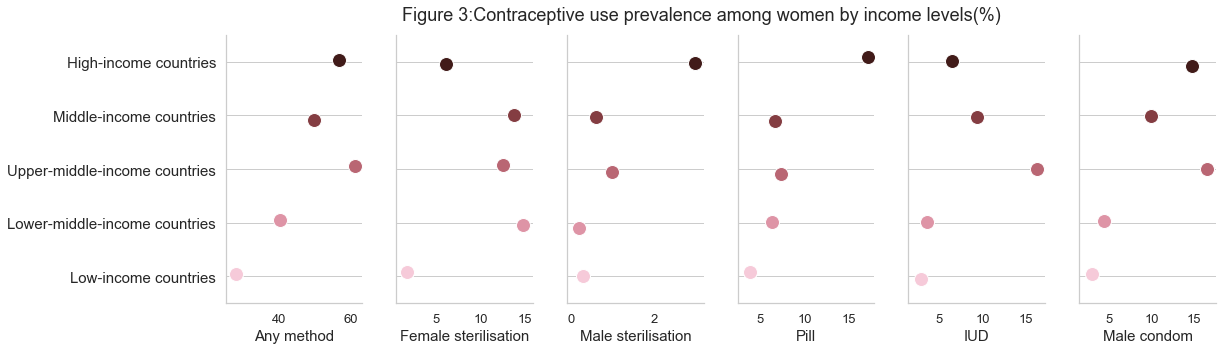

In [16]:
## plot setup，we use PariGrid to setup the multiple plotting format.b
sns.set(style="whitegrid",rc={'font.size': 15, 'axes.labelsize': 15, 'legend.fontsize': 15, 
   'axes.titlesize': 15, 'xtick.labelsize': 13, 'ytick.labelsize': 15})
inc= sns.PairGrid(inc_contra,
                 x_vars=inc_contra.columns[1:7], y_vars=["area"],
                 height=5, aspect=.5)
inc.map(sns.stripplot, size=14, orient="h",
      palette="ch:s=1,r=-.1,h=1_r", linewidth=1, edgecolor="w")
inc.set(ylabel="")

## change grid orientation
for ax in inc.axes.flat:
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

## setup title    
inc.fig.subplots_adjust(top=0.9) ## title position
inc.fig.suptitle('Figure 3:Contraceptive use prevalence among women by income levels(%)', fontsize=18)

If we divide countries into income strata, high-income countries are more likely to adopt short acting contraceptive methods such as hormonal pills and male condoms. Middle income countries present a mixed pattern that both short- and long-acting methods are widely used. Low income countries are less likely to uptake any contraception and female sterilisation is more common than other contraceptive method in these developing countries. 

### Country specific trend

Now, let's see how contraceptive use changed for the past few decades. I select 12 major countries to examine their trend. A trick I used here to select my target countries is to import the pycountry module. This module contains the information of all countries, including their country codes. I first extract the corresponding country ISO code and save them into a list, then select the counties with corresponding codes from "country_trend" dataset and save it as a new dataset "subcountry".

In [14]:
## Select 12 countries to examine the trends
countryname=[]
for i in ['USA', 'CAN', 'GBR','FRA','DEU','MEX' ,'JPN','KOR','CHN','IND','AUS','TUR']: 
    name=pycountry.countries.get(alpha_3=i).numeric
    countryname.append(int(name))
subcountry=country_trend.loc[country_trend['ISO code'].isin(countryname),\
                             ['ISO code','area', 'Survey\nend year','Any method','Female\nsterilization',\
                              'Pill', 'Male condom'] ]

In [15]:
## rename column names 
subcountry = subcountry.rename(columns = {'ISO code':'iso','Survey\nend year':'year','Any method':'Any method' ,\
                                          'Female\nsterilization':'Female sterilization', \
                                          'Pill':'Pill', 'Male condom': 'Male condom'})


In [16]:
## use pivot table function from pandas to present the mean of contraceptive prevalence of each country.
country_mean=round(pd.pivot_table(subcountry, values=['Any method','Female sterilization','Pill','Male condom'], 
               index=['area'],aggfunc=np.mean),2)
country_mean

,Any method,Female sterilization,Male condom,Pill
area,,,,
Australia,67.91,11.07,12.63,22.58
Canada,77.36,19.04,20.32,21.22
China,80.71,27.76,6.51,2.77
France,76.27,5.49,6.35,33.78
Germany,69.04,7.57,6.49,39.06
India,45.60,30.22,4.29,2.26
Japan,50.26,2.73,37.52,1.04
Mexico,58.74,20.37,3.54,9.10
Republic of Korea,62.99,16.81,10.22,3.66


#### Here I try to use bokeh module to create interactive plots, put them into multiple tabs.
These figures presents the mean levels of each contraceptive methods use for 12 countries

In [17]:
## define a function to plot various methods for each country in a bar chart
source = ColumnDataSource(country_mean)
name=sorted(list(set(subcountry["area"])))
color=factor_cmap('area', palette=Paired[12], factors=name)

def plot(title, cate, right):
    p1=figure(plot_height=400,y_range=name, min_border=20, toolbar_location=None, title=title)
    p1t=p1.hbar(cate, right=right, left=0, height=0.9, source=source, legend="",
            fill_color= color, line_color='black')
    ## hovertool is used to create interactive labels
    p1.add_tools(HoverTool(renderers=[p1t], tooltips=[("Method","@{"+right+"}{0.0}")],mode='mouse'))
    tab = Panel(child=p1, title=title)
    output_notebook()
    return tab


In [18]:
# Note: this plot only view locally. Can't be display via github
tab1=plot("Any contraceptive method", 'area',"Any method")
tab2=plot("Female sterilization", 'area',"Female sterilization")
tab3=plot("Male condom", 'area',"Male condom")
tab4=plot("Pill", 'area',"Pill")
tabs = Tabs(tabs=[ tab1, tab2, tab3, tab4 ])
show(tabs)

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

From the above figures, contraceptions are most commonly used in China and United Kingdom. Female sterilization is frequently used among developing countries such as India, China, Mexico and Korea. However, the US and Canada maintain a high level of female sterilization prevalence (16.3% and 19%, respectively) compared with other high income countries (for example, France is 5.5%). Women living in European countries such as Germany and France are more likely to choose pills. Male condoms are especially common in Japan as a major contraceptive method. 

#### How about the country specific trend
I use information after 1980. I first reshape this data from wide format into a long format for ploting. Then create 12 line plots to present contraceptive trend for various countries.

In [22]:
## Only examine the trend since 1980
subcountry = subcountry.query('year>1979')
long_subc = pd.melt(subcountry, id_vars=['area','iso', 'year'],\
                    value_vars=['Any method','Female sterilization','Pill','Male condom'])
                          

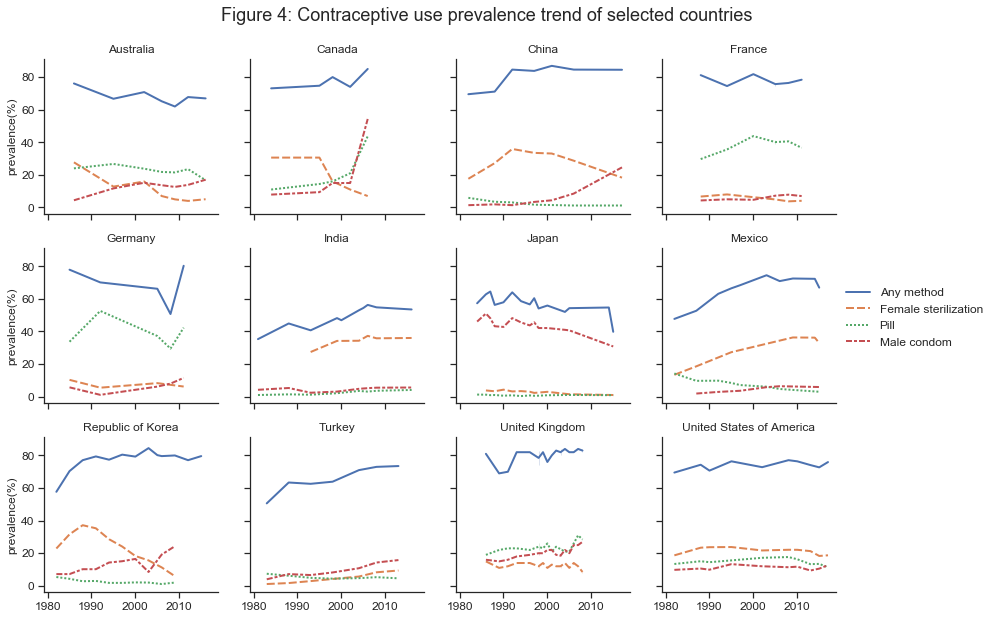

In [23]:
#Parameters set up
sns.set(style="ticks",rc={"lines.linewidth": 2,'xtick.labelsize': 12, 'ytick.labelsize': 12,\
                          'font.size': 15, 'axes.labelsize': 12, 'legend.fontsize': 12})

g=sns.relplot(x="year", y="value",
            hue="variable", 
            kind="line",col="area",style="variable", col_wrap=4, height=3,data=long_subc)
(g.set_ylabels("prevalence(%)")
  .set_xlabels(""))
g._legend.texts[0].set_text("") ## remove legend title 

#title for the plot
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Figure 4: Contraceptive use prevalence trend of selected countries', fontsize=18)

# change column titles for each plot.
name=list(set(subcountry['area']))
titles=sorted(name)
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)


Figure 4 illustrates country-specific trend of contraceptive use. Overall, there is an upward trend of contraceptive use among different countries except for Japan and Australia. In most countries, the prevalence of female sterilization is declining. Male condoms are more and more popular in the recent years. The use of pills is stable in most countries. We observe an increase of pill use in Canana and the UK in more recent years. The use of contraceptive method has been stable in the US since 1980. Compared with European countries, the prevalence of female sterilization is much higher, whereas the short-acting methods remain low in the US.

### Contraceptive Trend of the United States (an interactive plot)

In [19]:
## Note: this plot only view locally. Can't be display via github
## select usa data 
CODE=int(pycountry.countries.get(alpha_3='USA').numeric)
usa=country_trend.loc[country_trend['ISO code']== CODE]

In [20]:
## prepare data for plotting
usa_trend = usa.iloc[:,[3,7,8,9,12,13,21]]
usa_trend = usa_trend.rename(columns = {'Survey\nend year':'year','Female\nsterilization':'Female sterilization',
                                        'Male\nsterilization':'Male sterilization'})
usa_trend=usa_trend.interpolate(method ='linear') # fill NaN use interpolate method

In [21]:
## draw an interactive plot using bokeh 

tools_to_show = 'box_zoom, save, reset, tap, wheel_zoom, pan'  ## set up side bar tools
# set up the plotting canvas 
p = figure(plot_width=850, plot_height=450, x_axis_label='Year', y_axis_label='Prevalence (%)',tools=tools_to_show)
p.title.text = 'Contraceptive prevalence in the United States: 1955-2017'


source = ColumnDataSource(usa_trend)
for method,  color in zip(list(usa_trend.columns)[1:],  Spectral6) :
    p.line(usa_trend['year'], usa_trend[method],  line_width=2, color=color, alpha=0.8,
             muted_color=color, muted_alpha=0.1, legend= method)

## use source will lead to an error in legend but with source specified in the plot will be desirable to add hovertool.
## the trick is making the scatter plot connected with hovertool without showing legend

    plt=p.circle('year', method, source=source, size=5, color=color, alpha=0.6) 
## use +method+ to remove the heading and trending space 
    p.add_tools(HoverTool(renderers=[plt], tooltips=[("Year","@year"), 
                                                     ("Prevalence","@{"+method+"}{0.0}")],
                                                     mode='mouse'))

p.legend.location = "top_left"
p.legend.click_policy="mute"


p.legend.glyph_height = 12
p.legend.glyph_width = 8
p.legend.label_text_font_size ='8pt'

output_notebook()
#output_file("markers.html", title="markers.py example")
show(p)     


Loading BokehJS ...

If we take a close look at the contraceptive prevalence in the US since 1955, clearly, an increasing trend of female sterilization is prominent with a slight decline in more recent years. The use of pills was quite common in the 1970s and decreased since then. The use of long-acting reversible contraceptive methods such as IUD began to increase since 1995. Male condoms and male sterlization account for 20% among all contraceptive methods in the US. A small portion of people adopt withdrawal, which acounts for around 5% in all contraceptive methods.

### Summary

As we have found, the contraceptive prevalence varies across countries and regions. Contraception is widely used in high income/developed countries whereas the prevalence of contraceptive use in less developed countries remains low. Women living in the US are more likely to rely on sterilization as an effective method to avoid unintended pregnancy, which is quite the opposite in countries such as France, Germany and Japan. Pills and male condoms have also been commonly used since 1990s in the US. The use of IUD has increased with the advent of new options. The observed pattern triggers more questions, for example, who are those women choosing female sterilization as a contraceptive method. I suspect there should be cohort differences when practice contraception. Older cohort may be more likely to adopt sterilization but younger cohort may rely on short acting methods. Race, education and marital status would also influence women's contraceptive preferences. The next step is to employ national data to further break down social categories and permit a close investigation of how contraceptive use is determined by demographic, social and behavioral factors. 


As for data visualization, python with a variety of modelus, is a handy tool to present highly flexible and beatiful plots and figures. The thing is to master each module needs time and practices. Seaborn is a visually attractive module that is suitable for most basic plots. bokeh has nice functionality to create interactive plots. It is also capable to graph geograpic data. matplotlib is mostly used for academic plotting, I found the code is not so intuitive though. 